In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


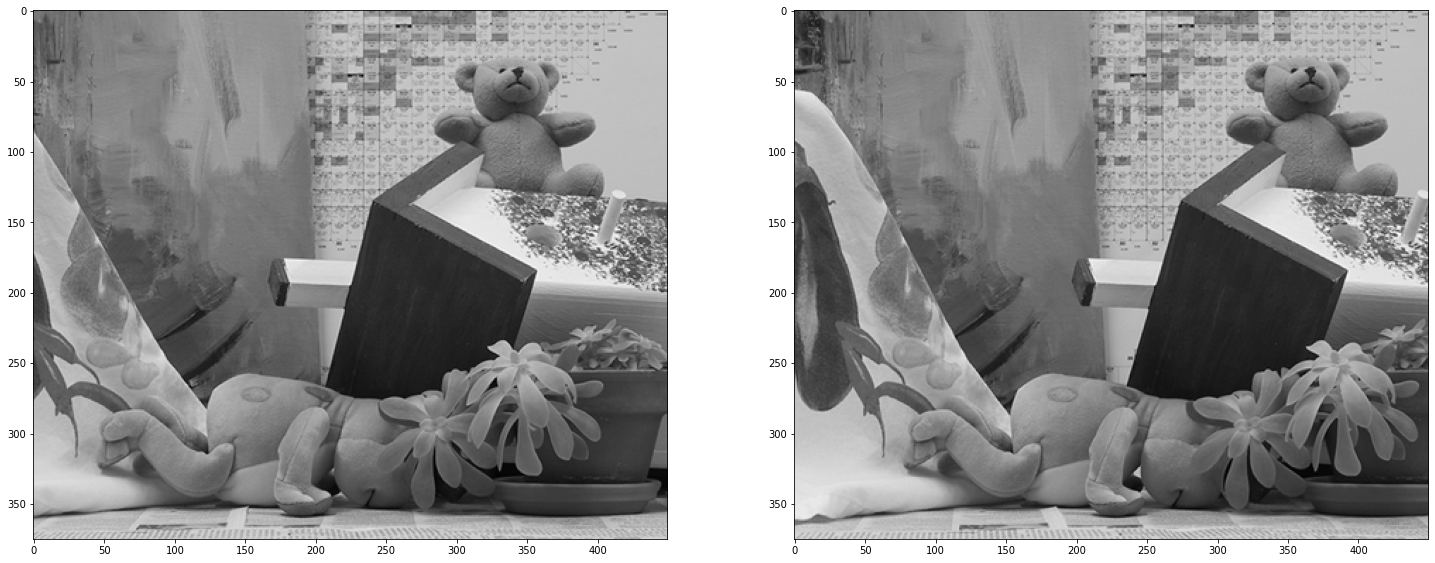

In [2]:
left_image = Image.open("./images/l3.png").convert('L')
left_image = np.asarray(left_image, dtype=np.int32)

right_image = Image.open("./images/r3.png").convert('L')
right_image = np.asarray(right_image, dtype=np.int32)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
ax[1].imshow(left_image, cmap="gray")
ax[0].imshow(right_image, cmap="gray")


In [3]:
def norm_ssd(_left_pixel, _right_pixel, sigma=2):
    return ((_left_pixel - _right_pixel) ** 2) / (sigma ** 2)

In [4]:
def match_scanLine(_left_row, _right_row):
    N = _left_row.shape[0]

    D = np.ones((N, N))  # the cost matrix
    _match_matrix = np.zeros((N, N))

    occlusion_cost = 1

    # base cases
    D[0, 1:] = np.arange(start=1, stop=N) * occlusion_cost
    D[1:, 0] = np.arange(start=1, stop=N) * occlusion_cost
    D[0][0] = norm_ssd(_left_row[0], _right_row[0])

    for i in range(1, N):
        for j in range(1, N):
            c1 = D[i - 1][j - 1] + norm_ssd(_left_row[i], _right_row[j])
            c2 = D[i - 1][j] + occlusion_cost
            c3 = D[i][j - 1] + occlusion_cost

            if c1 < c2:
                if c1 < c3:
                    # both disparity maps at this position are set to the absolute difference between i and j
                    D[i][j] = c1
                    _match_matrix[i][j] = 1
                else:
                    # corresponds to skipping a pixel in Ir, and the right disparity map of j is zero
                    D[i][j] = c3
                    _match_matrix[i][j] = 3
            else:
                if c2 < c3:
                    # skipping a pixel in Il, so the left disparity map of i is zero
                    D[i][j] = c2
                    _match_matrix[i][j] = 2
                else:
                    # corresponds to skipping a pixel in Ir, and the right disparity map of j is zero
                    D[i][j] = c3
                    _match_matrix[i][j] = 3

    return _match_matrix


In [5]:
def construct_path(_match_matrix):
    N = _match_matrix.shape[0]
    path = np.zeros((N, N))
    i = j = N - 1
    while i != 0 and j != 0:
        k = _match_matrix[i][j]
        if k == 1:
            i -= 1
            j -= 1
            path[i][j] = 200
        elif k == 2:
            i -= 1
            path[i][j] = 200
        elif k == 3:
            j -= 1
            path[i][j] = 200

    while i > 0:
        i -= 1
        path[i][j] = 200

    while j > 0:
        j -= 1
        path[i][j] = 200

    return path

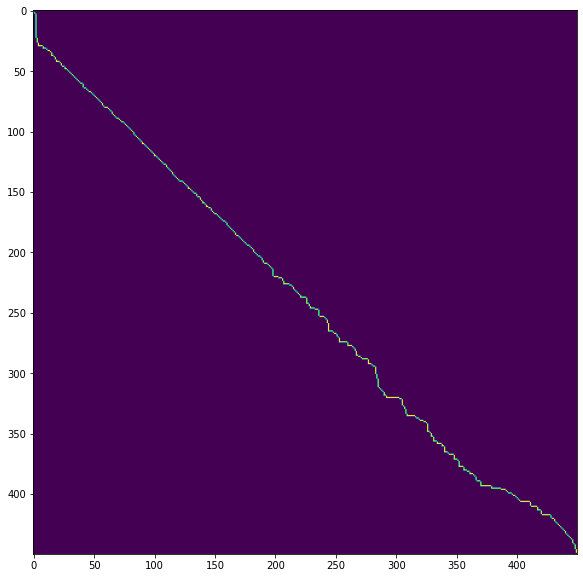

In [6]:
match_matrix = match_scanLine(left_image[50], right_image[50])
path_map = construct_path(match_matrix)
plt.figure(figsize=(10, 10))
plt.imshow(path_map)
plt.show()

In [7]:
def left_disparity_row(_match_matrix):
    N = _match_matrix.shape[0]
    path = np.zeros(N)
    i = j = N - 1
    while i != 0 and j != 0:
        k = _match_matrix[i][j]
        if k == 1:
            i -= 1
            j -= 1
            path[i] = abs(i - j)
        elif k == 2:
            i -= 1
            path[i] = 0
        elif k == 3:
            j -= 1

    return path

In [8]:
def right_disparity_row(_match_matrix):
    N = _match_matrix.shape[0]
    path = np.zeros(N)
    i = j = N - 1
    while i != 0 and j != 0:
        k = _match_matrix[i][j]
        if k == 1:
            i -= 1
            j -= 1
            path[j] = abs(i - j)
        elif k == 2:
            i -= 1
        elif k == 3:
            j -= 1
            path[j] = 0

    return path

In [9]:
def disparity_map(_left_image, _right_image):
    height, width = _left_image.shape
    left_disparity = np.zeros(_left_image.shape)
    right_disparity = np.zeros(_left_image.shape)

    for row in range(height):
        match_mat = match_scanLine(left_image[row], right_image[row])
        left_disparity[row, :] = left_disparity_row(match_mat)
        right_disparity[row, :] = right_disparity_row(match_mat)

    return left_disparity, right_disparity


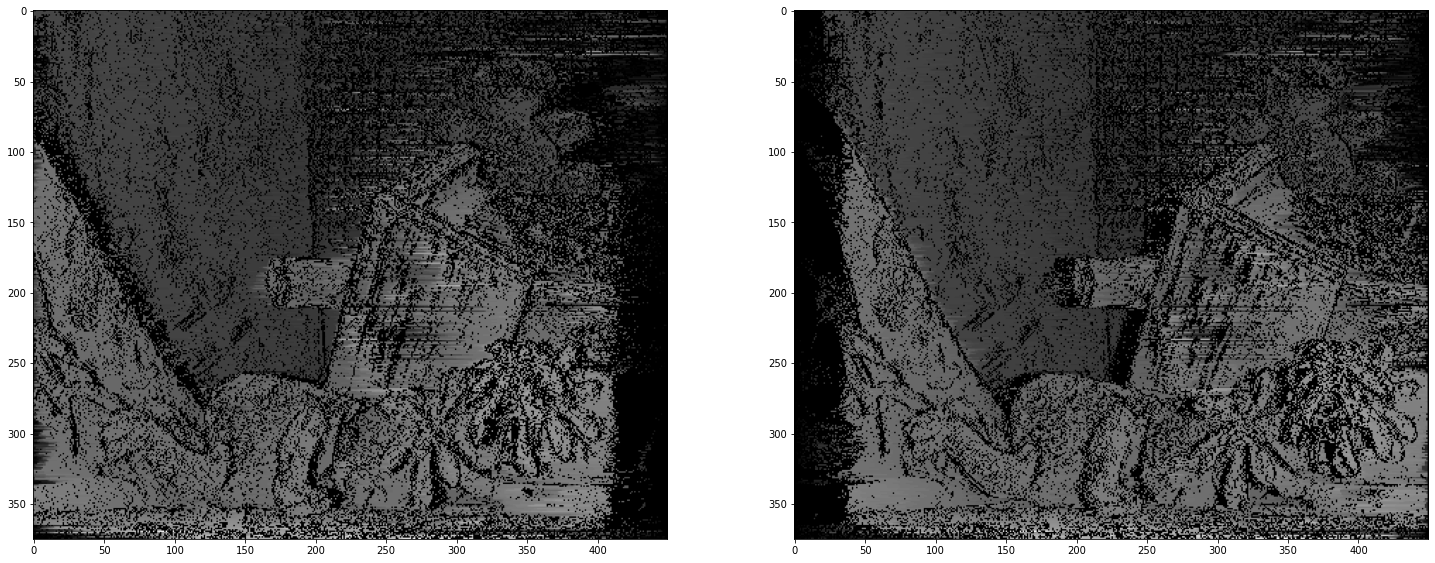

In [10]:
left_disparity_map, right_disparity_map = disparity_map(left_image, right_image)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
ax[1].imshow(left_disparity_map, cmap="gray")
ax[0].imshow(right_disparity_map, cmap="gray")